# PROJET DE FIN D'ANNEE
### Réalisé par :Firas GRAJA et Mahdi GUIDARA
### Sujet: Système de détection des ralentisseurs de vitesse

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator

2023-05-30 12:15:41.042909: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 12:15:42.224552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-30 12:15:42.227276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 12:15:45.317384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = "/home/mahdi/Bureau/pfa/myData 42 classes/"  # folder with all the class folders
labelFile = "/home/mahdi/Bureau/pfa/labels 42/labels 42.ods" # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

### Notre Base de données
La base de données "PANNEAUX IMAGES" que nous avons constituée comprend 33 500 images représentant divers panneaux routiers. Ces images sont réparties en 43 catégories distinctes. Bien que notre base de données couvre tous les types de panneaux présents sur les routes, notre projet se concentre spécifiquement sur la prédiction d'une seule classe : celle des panneaux de ralentisseurs de vitesse.

In [3]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(x) + "/" + y)
        if curImg is not None:
            curImg = cv2.resize(curImg, (32, 32))
            images.append(curImg)
            classNo.append(count)
        else:
            print(f"Could not read file: {y}")
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)


Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [5]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [6]:
import pyexcel_ods
data = pyexcel_ods.get_data(labelFile)
# Assuming the data is in the first sheet of the ODS file
data = data[list(data.keys())[0]]
data = pd.DataFrame(data[1:], columns=data[0])
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


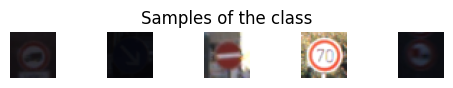

In [7]:
num_of_samples = []
num_classes = noOfClasses
cols = 5
fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=(5, 100))
fig.tight_layout()
for i in range(cols):
    x_selected = X_train
    axs[i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
    axs[i].axis("off")
    if i == 2:
        axs[i].set_title("Samples of the class")
        num_of_samples.append(len(x_selected))


### Répartition du jeu données d'entrainement
En examinant la répartition du jeu de données d'entraînement dans la figure, nous constatons une inégalité dans le nombre d'images par classe. Cette disparité peut entraîner des problèmes tant dans la construction du modèle que dans la phase de prédiction. Afin de remédier
à cette situation, nous avons pris la décision d'effectuer un traitement sur notre base de données et d'appliquer des techniques d'augmentation des données. Cela nous permettra d'équilibrer les différentes classes et d'améliorer les performances globales de notre modèle.

[22271]


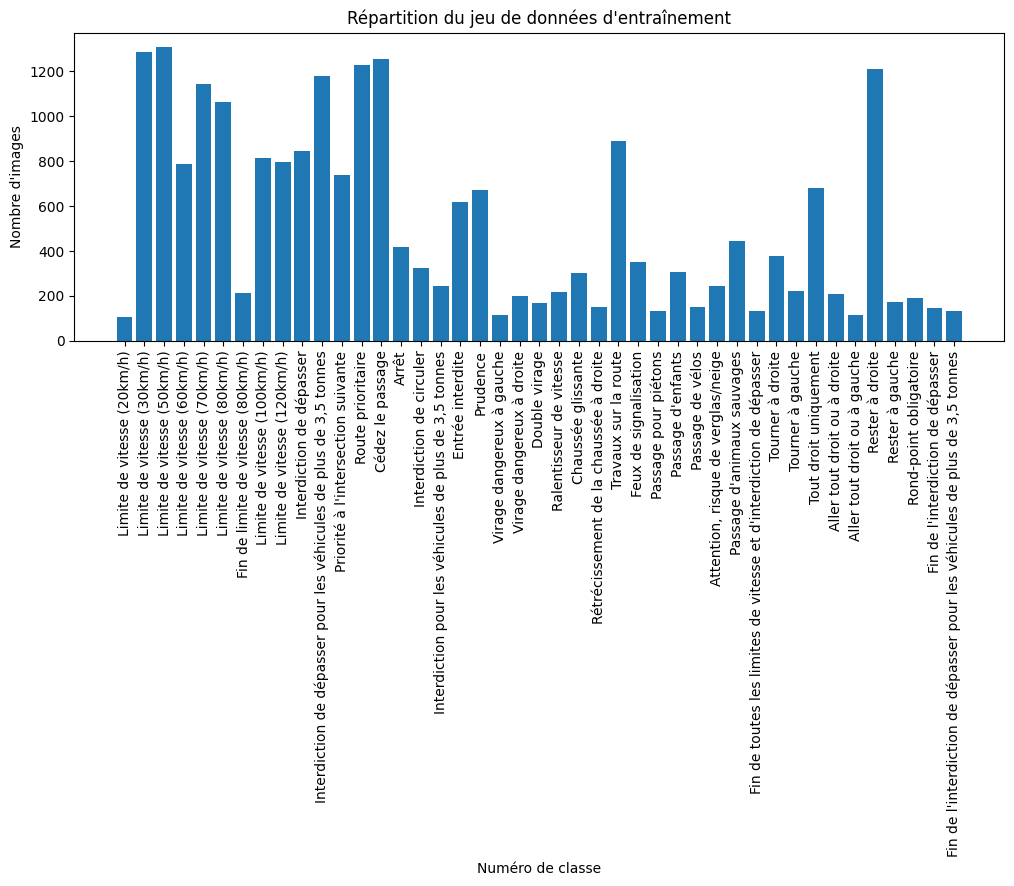

In [8]:
import matplotlib.pyplot as plt
print(num_of_samples)

# Noms des classes
noms_classes = [
    'Limite de vitesse (20km/h)', 'Limite de vitesse (30km/h)', 'Limite de vitesse (50km/h)', 'Limite de vitesse (60km/h)',
    'Limite de vitesse (70km/h)', 'Limite de vitesse (80km/h)', 'Fin de limite de vitesse (80km/h)', 'Limite de vitesse (100km/h)',
    'Limite de vitesse (120km/h)', 'Interdiction de dépasser', 'Interdiction de dépasser pour les véhicules de plus de 3,5 tonnes',
    'Priorité à l\'intersection suivante', 'Route prioritaire', 'Cédez le passage', 'Arrêt', 'Interdiction de circuler',
    'Interdiction pour les véhicules de plus de 3,5 tonnes', 'Entrée interdite', 'Prudence', 'Virage dangereux à gauche',
    'Virage dangereux à droite', 'Double virage', 'Ralentisseur de vitesse', 'Chaussée glissante', 'Rétrécissement de la chaussée à droite',
    'Travaux sur la route', 'Feux de signalisation', 'Passage pour piétons', 'Passage d\'enfants', 'Passage de vélos',
    'Attention, risque de verglas/neige', 'Passage d\'animaux sauvages', 'Fin de toutes les limites de vitesse et d\'interdiction de dépasser',
    'Tourner à droite', 'Tourner à gauche', 'Tout droit uniquement', 'Aller tout droit ou à droite', 'Aller tout droit ou à gauche',
    'Rester à droite', 'Rester à gauche', 'Rond-point obligatoire', 'Fin de l\'interdiction de dépasser', 'Fin de l\'interdiction de dépasser pour les véhicules de plus de 3,5 tonnes'
]

# Nombre d'échantillons par classe
num_of_samples = []

for i in range(num_classes):
    num_of_samples.append(len(np.where(y_train == i)[0]))

# Visualisation de la distribution du jeu de données d'entraînement
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Répartition du jeu de données d'entraînement")
plt.xlabel("Numéro de classe")
plt.ylabel("Nombre d'images")
plt.xticks(range(0, num_classes), noms_classes, rotation='vertical')
plt.show()


### L'augmentation de la base de données
L'augmentation de la base de données, également appelée augmentation des données, est une technique utilisée en apprentissage automatique pour augmenter la quantité de données d'entraînement disponible. Cela consiste à appliquer une série de transformations ou de manipulations aux données existantes, tout en maintenant l'étiquette ou la classe d'origine, afin de créer de nouvelles instances de données.

Différentes techniques de filtrage sont appliquées pour augmenter la variété des données d'entraînement. Le décalage horizontal et vertical, le zoom avant/arrière, le cisaillement et la rotation aléatoire sont utilisés pour créer de nouvelles instances de données à partir des images
existantes.

Après avoir configuré les transformations, le générateur de données est adapté aux images d'entraînement. Ensuite, des lots d'images et de labels augmentés sont générés à l'aide de ce générateur.

L'objectif de cette augmentation de la base de données est de rendre le modèle plus résistant et capable de généraliser à partir d'un plus grand nombre de variations dans les données. Cela permet également de pallier le déséquilibre entre les différentes classes de données, en générant des exemples supplémentaires pour les classes moins représentées.

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(list(map(preprocessing, X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow("GrayScale Images",
           X_train[random.randint(0, len(X_train) - 1)])  # TO CHECK IF THE TRAINING IS DONE PROPERLY

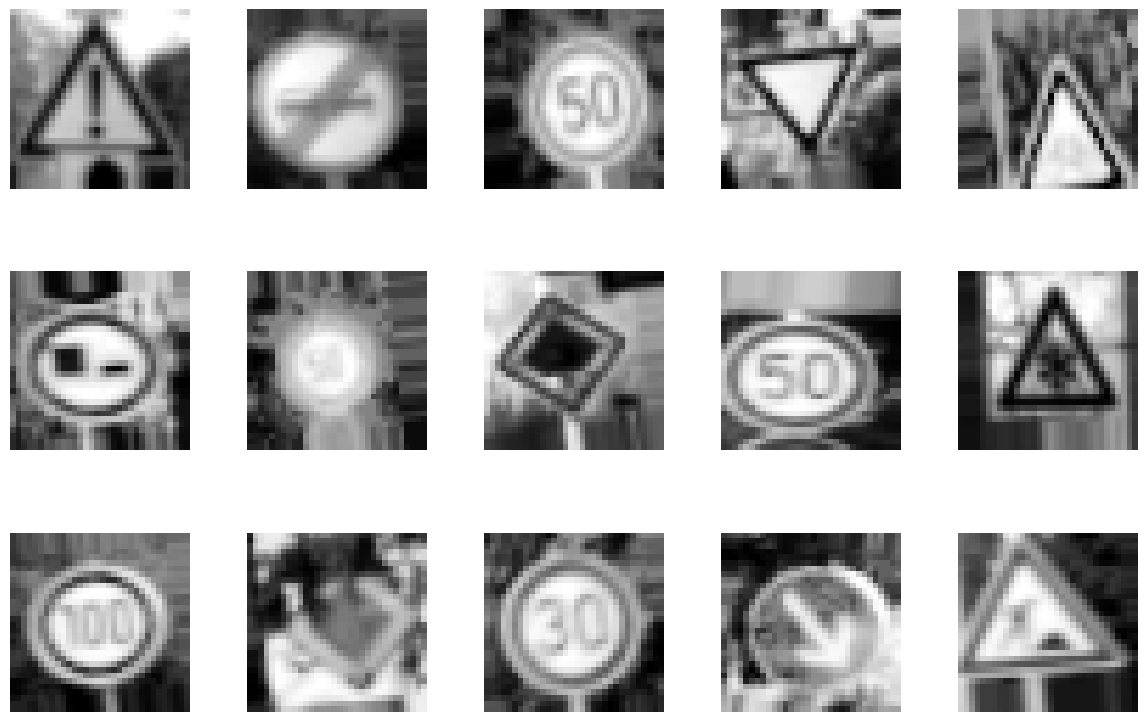

In [10]:
import matplotlib.pyplot as plt

dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

X_train = X_train.reshape(-1, imageDimesions[0], imageDimesions[1], 1)

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

# Affichage des échantillons d'images augmentées
fig, axs = plt.subplots(3, 5, figsize=(12, 8))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_batch[i].reshape(imageDimesions[0], imageDimesions[1]), cmap='gray')
    ax.axis('off')

plt.show()

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


### Description du modèle de détection d'objets basé sur un réseau de neurones convolutifs (CNN) utilisé dans le projet

On a utilisé ce modèle de détection d'objets pour reconnaître et localiser les panneaux de ralentisseur de vitesse en temp réel. Le modèle est défini comme une séquence de couches qui
sont empilées les unes sur les autres.

La première couche est une couche de convolution (Conv2D) qui prend une image en entrée et extrait des caractéristiques en appliquant des filtres convolutionnels. Cette couche a une sortie de forme (None, 28, 28, 60) et contient 1 560 paramètres.

Ensuite, on a une autre couche de convolution (Conv2D) qui continue à extraire des caractéristiques de l'image. Cette couche a une sortie de forme (None, 24, 24, 60) et comprend 90 060 paramètres.

Pour réduire la dimensionnalité et extraire les caractéristiques les plus importantes, on utilise une couche de max pooling (MaxPooling2D) qui réduit la taille de l'image de moitié.

Cette couche a une sortie de forme (None, 12, 12, 60).
On répète le processus avec deux autres couches de convolution (Conv2D) et une autre couche de max pooling (MaxPooling2D). Ces couches permettent d'obtenir une représentation plus abstraite des caractéristiques de l'image.

Pour éviter le surapprentissage du modèle, on utilise une couche de dropout (Dropout) qui désactive aléatoirement certains neurones lors de l'entraînement. Cela aide à généraliser le modèle et à améliorer sa capacité de prédiction.

Ensuite, on a une couche flatten (Flatten) qui transforme les données en un vecteur à une seule dimension. Cela permet de connecter les couches convolutionnelles à des couches
entièrement connectées.

La couche dense (Dense) est une couche entièrement connectée qui prend lescaractéristiques extraites précédemment et les relie à une couche de 500 neurones. Cette couchea 240 500 paramètres. On utilise à nouveau une couche de dropout (Dropout) pour éviter lesurapprentissage.

La dernière couche dense (Dense) est la couche de sortie qui prédit les classes des objets détectés. Le nombre de neurones dans cette couche dépend du nombre de classes dans notre problème de détection d'objets.

In [11]:
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (5, 5)  
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  
    no_Of_Nodes = 500  
    model = Sequential()
    model.add((Conv2D(no_Of_Filters, size_of_Filter, input_shape=(imageDimesions[0], imageDimesions[1], 1),
                      activation='relu'))) 
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))  

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(noOfClasses, activation='softmax'))  

    model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy' if noOfClasses == 2 else 'categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val), 
    epochs=epochs_val, 
    validation_data=(X_validation, y_validation),
    shuffle=True
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

2023-05-30 12:17:09.819870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


446/446 [==============================] - 158s 352ms/step - loss: 2.4231 - accuracy: 0.3248 - val_loss: 0.7211 - val_accuracy: 0.8127
Epoch 2/10
446/446 [==============================] - 142s 318ms/step - loss: 1.1459 - accuracy: 0.6451 - val_loss: 0.3430 - val_accuracy: 0.8967
Epoch 3/10
446/446 [==============================] - 125s 280ms/step - loss: 0.7800 - accuracy: 0.7619 - val_loss: 0.1878 - val_accuracy: 0.9449
Epoch 4/10
446/446 [==============================] - 122s 273ms/step - loss: 0.6012 - accuracy: 0.8113 - val_loss: 0.1340 - val_accuracy: 0.9603
Epoch 5/10
446/446 [==============================] - 129s 290ms/step - loss: 0.4952 - accuracy: 0.8430 - val_loss: 0.0930 - val_accuracy: 0.9767
Epoch 6/10
446/446 [==============================] - 125s 280ms/step - loss: 0.4230 - accuracy: 0.8686 - val_loss: 0.0787 - val_accuracy: 0.9772
Epoch 7/10
446/446 [==============================] - 133s 297ms/step - loss: 0.3754 - accuracy: 0.8820 - val_loss: 0.0603 - val_accura

### Évaluation du model : Matrice de confusion
La matrice de confusion est un résumé des résultats de prédiction pour un problème particulier de classification. Elle compare les données réelles pour une variable cible à celles prédites par un modèle.

Voici la matrice de confusion complète qui représente la visualisation de toutes les classes présentes dans la base de données :

218/218 [==============================] - 9s 42ms/step


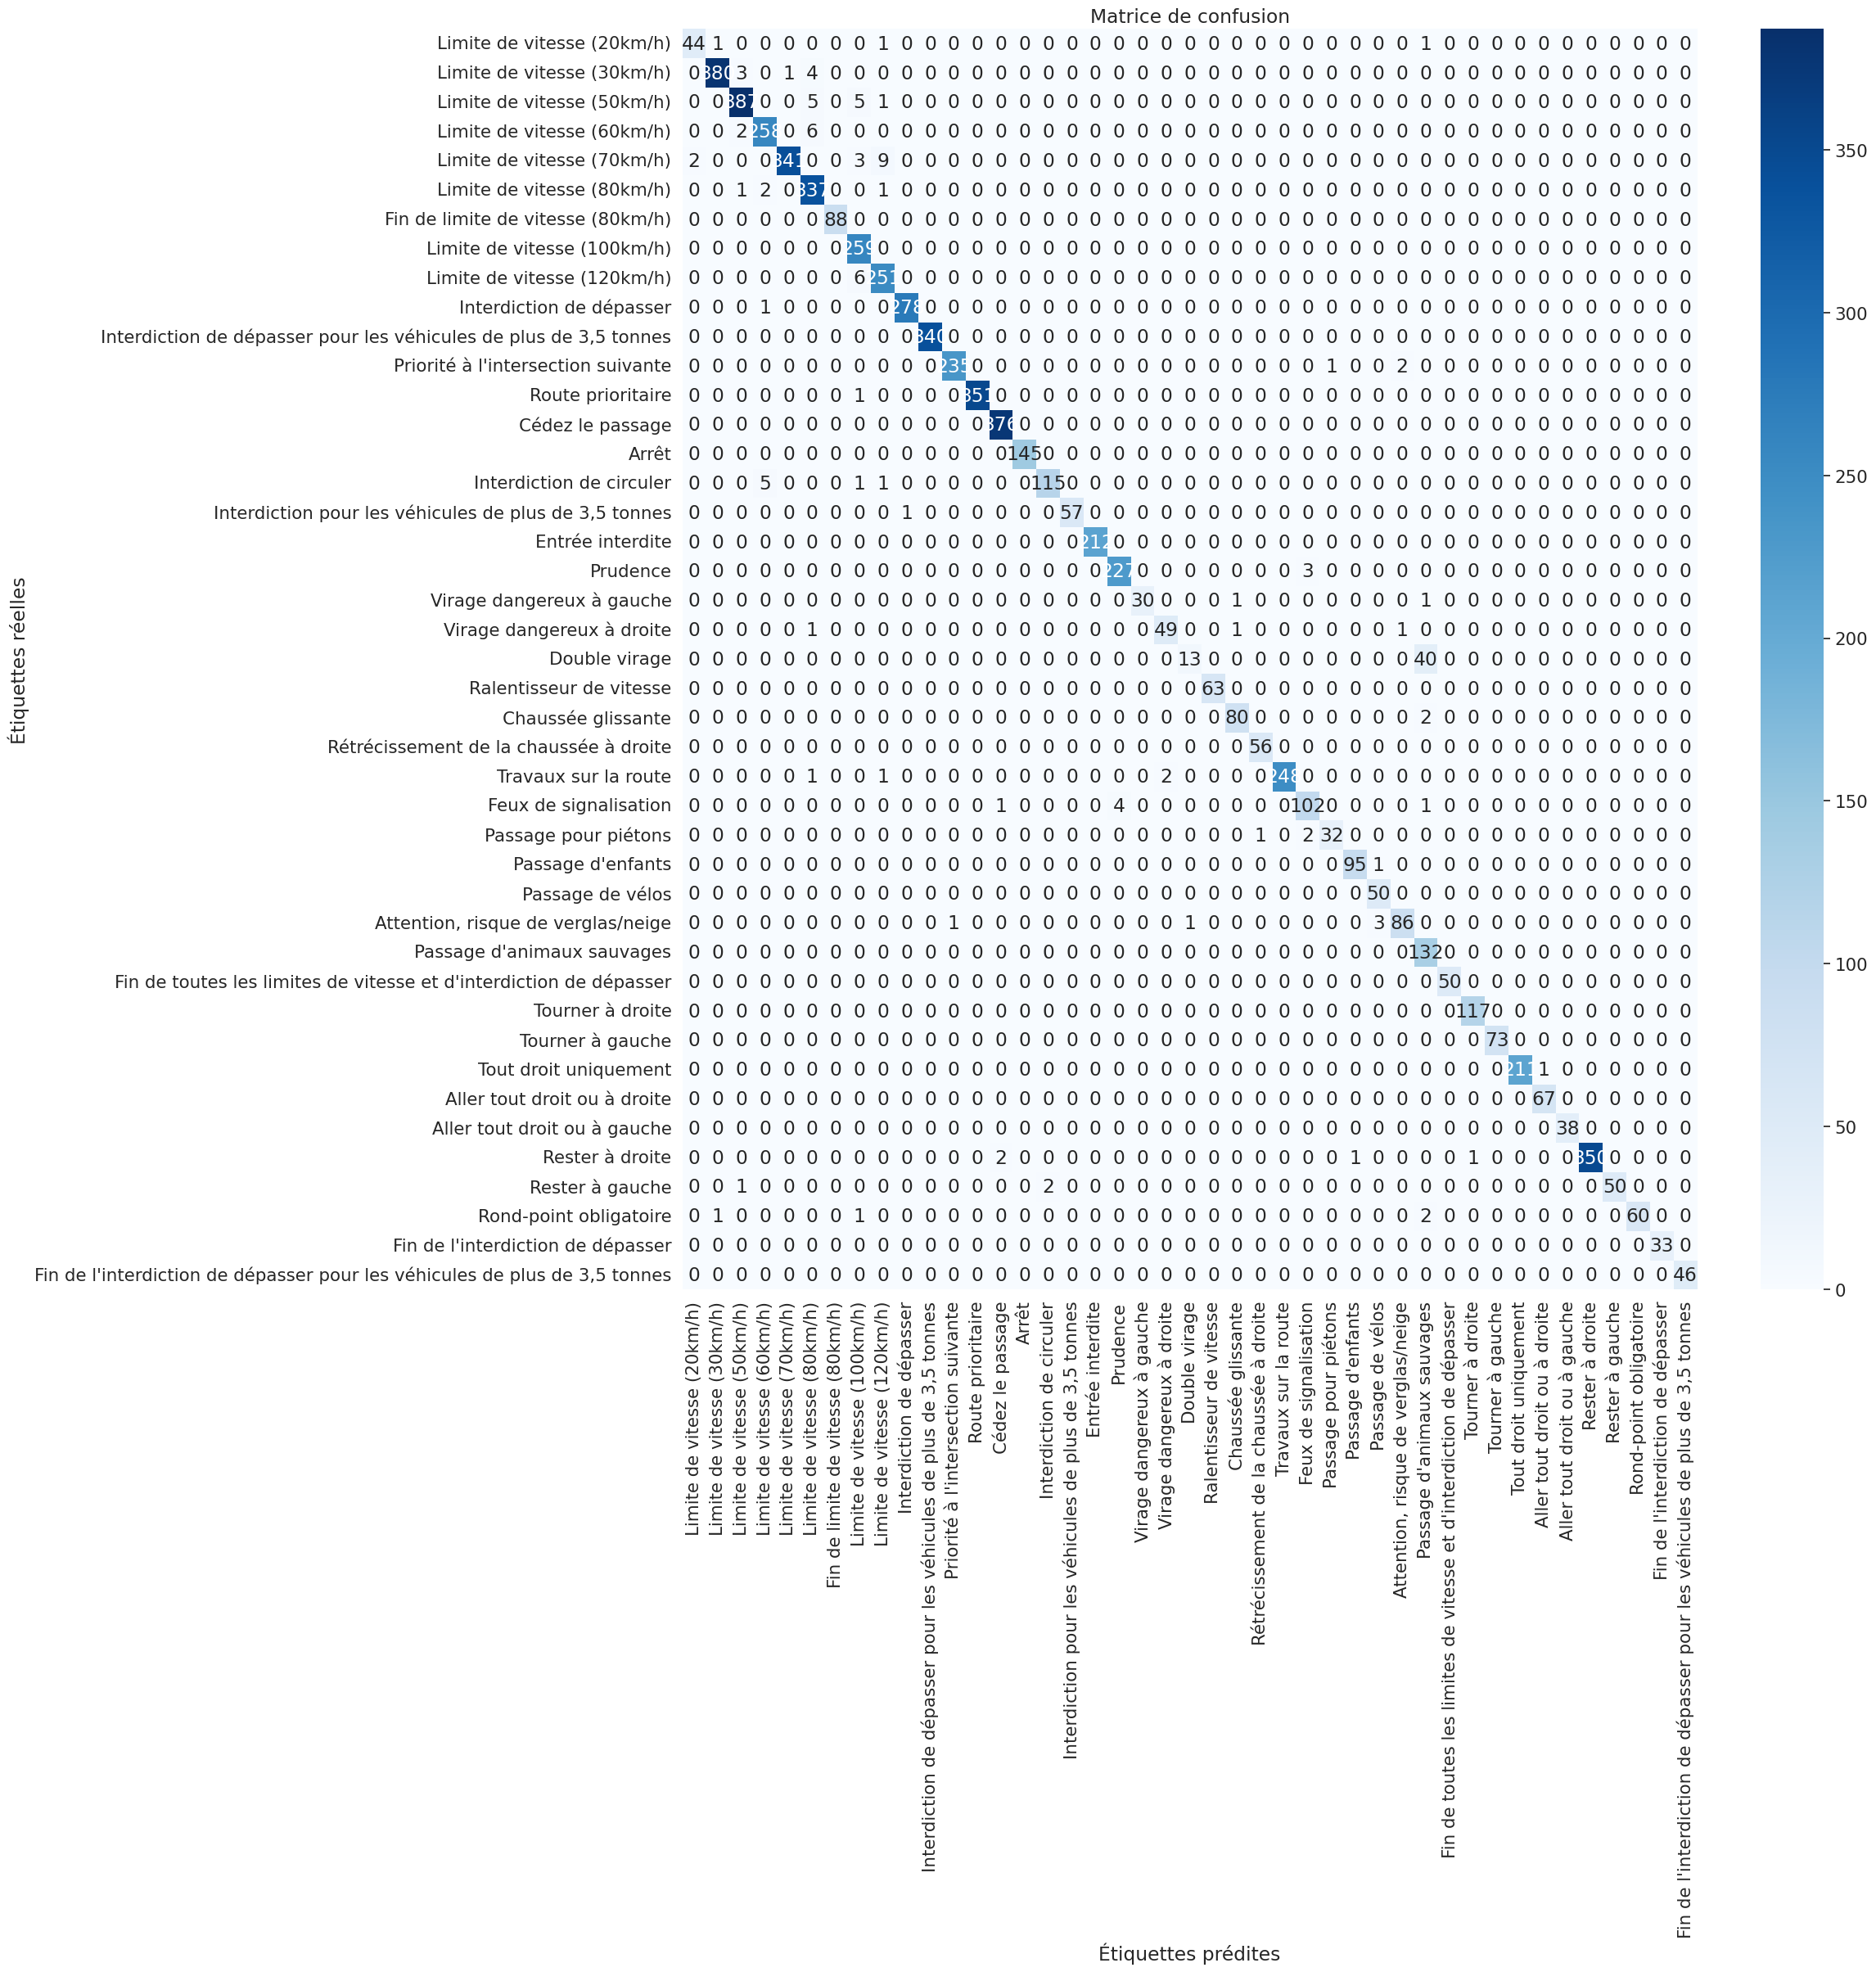

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Noms des classes
noms_classes = [
    'Limite de vitesse (20km/h)', 'Limite de vitesse (30km/h)', 'Limite de vitesse (50km/h)', 'Limite de vitesse (60km/h)',
    'Limite de vitesse (70km/h)', 'Limite de vitesse (80km/h)', 'Fin de limite de vitesse (80km/h)', 'Limite de vitesse (100km/h)',
    'Limite de vitesse (120km/h)', 'Interdiction de dépasser', 'Interdiction de dépasser pour les véhicules de plus de 3,5 tonnes',
    'Priorité à l\'intersection suivante', 'Route prioritaire', 'Cédez le passage', 'Arrêt', 'Interdiction de circuler',
    'Interdiction pour les véhicules de plus de 3,5 tonnes', 'Entrée interdite', 'Prudence', 'Virage dangereux à gauche',
    'Virage dangereux à droite', 'Double virage', 'Ralentisseur de vitesse', 'Chaussée glissante', 'Rétrécissement de la chaussée à droite',
    'Travaux sur la route', 'Feux de signalisation', 'Passage pour piétons', 'Passage d\'enfants', 'Passage de vélos',
    'Attention, risque de verglas/neige', 'Passage d\'animaux sauvages', 'Fin de toutes les limites de vitesse et d\'interdiction de dépasser',
    'Tourner à droite', 'Tourner à gauche', 'Tout droit uniquement', 'Aller tout droit ou à droite', 'Aller tout droit ou à gauche',
    'Rester à droite', 'Rester à gauche', 'Rond-point obligatoire', 'Fin de l\'interdiction de dépasser', 'Fin de l\'interdiction de dépasser pour les véhicules de plus de 3,5 tonnes'
]

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Convertir les prédictions du codage one-hot en étiquettes de classe
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Générer la matrice de confusion
matrice_confusion = confusion_matrix(y_true_labels, y_pred_labels)

# Visualiser la matrice de confusion
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.4)
sns.heatmap(matrice_confusion, annot=True, cmap="Blues", fmt="d", xticklabels=noms_classes, yticklabels=noms_classes)
plt.xlabel("Étiquettes prédites")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion")
plt.show()


Les mesures de précision, rappel et exactitude évaluent les performances d'un modèle de classification. La précision mesure les prédictions correctes parmi les prédictions positives.
Le rappel évalue la capacité du modèle à identifier les instances positives. L'exactitude mesure la précision globale du modèle. Des valeurs élevées indiquent de bonnes performances du modèle. Dans notre exemple, la précision est de 98%, le rappel de 97% et l'exactitude
de 97%.

In [27]:
from sklearn.metrics import precision_score, recall_score

# Calculate accuracy
total_samples = matrice_confusion.sum()
correct_predictions = matrice_confusion.diagonal().sum()
accuracy = correct_predictions / total_samples

# Calculate precision
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')

# Calculate recall
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.978735632183908
Precision: 0.9803930039144875
Recall: 0.978735632183908


Le classe "Autre panneaux" est une catégorie qui regroupe la fusion des 42 autres classes.
Notre base de données est équilibrée, et nous avons tenté de visualiser la matrice de confusion
en regroupant les prédictions en deux classes afin d'évaluer les performances du modèle de
manière plus claire.

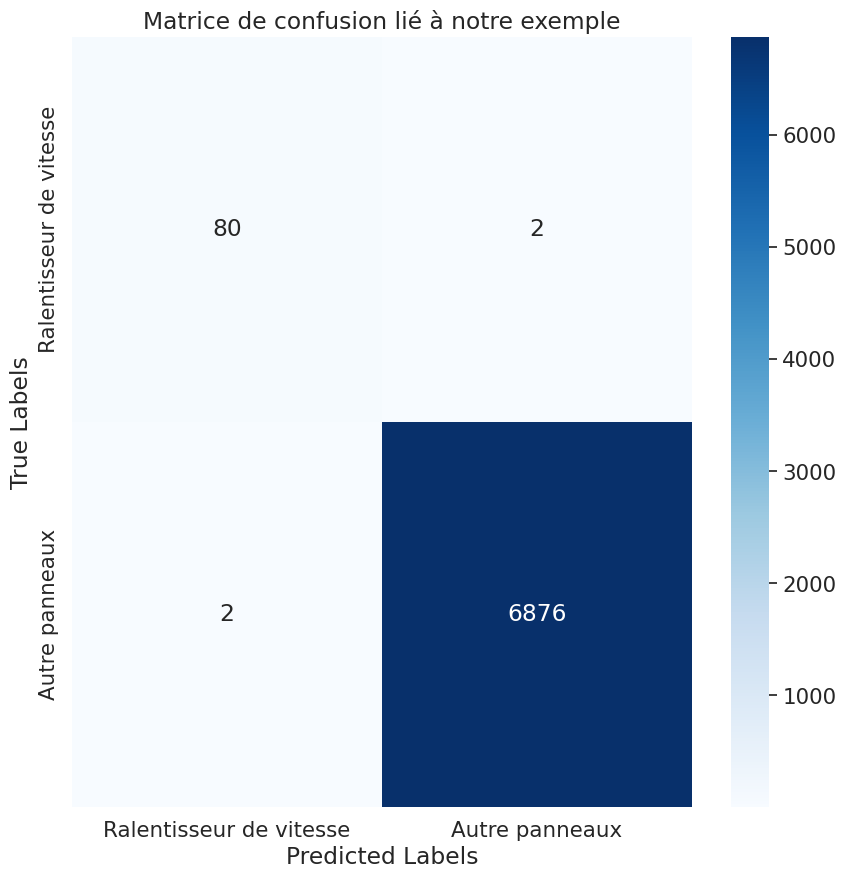

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the indices of the classes to be merged
class_indices_to_merge = [23]  # Index of "Ralentisseur de vitesse"

# Define the new class names
new_class_names = ["Ralentisseur de vitesse", "Autre panneaux"]

# Create a new confusion matrix by merging the rows and columns
new_confusion_matrix = np.zeros((2, 2))
new_confusion_matrix[0, 0] = matrice_confusion[class_indices_to_merge[0], class_indices_to_merge[0]]
new_confusion_matrix[0, 1] = np.sum(matrice_confusion[class_indices_to_merge[0], :]) - new_confusion_matrix[0, 0]
new_confusion_matrix[1, 0] = np.sum(matrice_confusion[:, class_indices_to_merge[0]]) - new_confusion_matrix[0, 0]
new_confusion_matrix[1, 1] = np.sum(matrice_confusion) - new_confusion_matrix[0, 0] - new_confusion_matrix[0, 1] - new_confusion_matrix[1, 0]

# Visualize the new confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.4)
sns.heatmap(new_confusion_matrix, annot=True, cmap="Blues", fmt=".0f", xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matrice de confusion lié à notre exemple")
plt.show()


In [ ]:
# save the model in the .h5 format
model.save('my_model5.h5')